In [88]:
import numpy as np
import matplotlib.pyplot as plt
try:
  import google.colab
except ImportError:
  from dolfin import *
else:
  try:
    from dolfin import *
  except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *
%matplotlib inline

In [89]:
# 1. Read the mesh for this problem

!wget "https://github.com/niravshah241/transient_heat_conduction_LSTM_PINN/archive/refs/heads/main.zip" -O "/tmp/github_files.zip"

zip_ref = zipfile.ZipFile("/tmp/github_files.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

mesh = Mesh("/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data/mesh.xml")
subdomains = MeshFunction("size_t", mesh, "/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data/mesh_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "/tmp/transient_heat_conduction_LSTM_PINN-main/mesh_data/mesh_facet_region.xml")


--2022-07-28 18:52:57--  https://github.com/niravshah241/transient_heat_conduction_LSTM_PINN/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/niravshah241/transient_heat_conduction_LSTM_PINN/zip/refs/heads/main [following]
--2022-07-28 18:52:57--  https://codeload.github.com/niravshah241/transient_heat_conduction_LSTM_PINN/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/github_files.zip’

/tmp/github_files.z     [ <=>                ] 638.90K  --.-KB/s    in 0.1s    

2022-07-28 18:52:58 (4.21 MB/s) - ‘/tmp/github_files.zip’ saved [654233]



In [90]:
# 2A. Create Finite Element space (Lagrange P1)
VT = FunctionSpace(mesh,"CG",1)
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
ds_sym = ds(2) + ds(3) + ds(6)
ds_bottom = ds(1)
ds_sf = ds(5) + ds(7) + ds(8) + ds(9) + ds(10)
ds_top = ds(4) + ds(11) + ds(12) + ds(13) + ds(14)
ds_out = ds(15)
dx_cc1 = dx(1) 
dx_cc2 = dx(2)
dx_cc2_upper = dx(4)
dx_bb_surround = dx(3)
dx_cc = dx(6)
dx_cb = dx(5)
dx_ss = dx(7)
T_, psi = TrialFunction(VT), TestFunction(VT)
T = Function(VT)

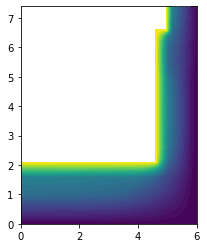

In [91]:
Q = Constant(0.) #Source term
T_left = Expression("300.+600.*t", degree=2, t=0.)
T_right = Constant(300.)

#Thermal conductivity in two subdomains
k_cc1 = 15.5
k_cc2 = k_cc2_upper = 39.5
k_bb_surround = 20.2
k_cb = 5.5
k_ss = 48.
k_cc = as_tensor([[7.,0],[0,5.]])

t_max = 2.
num_steps = 50
dt = t_max/num_steps

#Boundary value
bcs = [DirichletBC(VT,T_left,boundaries,5),DirichletBC(VT,T_left,boundaries,7),DirichletBC(VT,T_left,boundaries,8),DirichletBC(VT,T_left,boundaries,9),DirichletBC(VT,T_left,boundaries,10),\
       DirichletBC(VT,T_right,boundaries,15),DirichletBC(VT,T_right,boundaries,1)]

#Intial value
T_previous = interpolate(Constant(300.),VT)
x0 = Expression("x[0]",element=VT.ufl_element())
x1 = Expression("x[1]",element=VT.ufl_element())

F_T = inner(psi,T_)*dx + dt * inner(k_cc1*grad(T_),grad(psi)) * dx_cc1 + dt * inner(k_cc2*grad(T_),grad(psi)) * dx_cc2 + dt * inner(k_cc2_upper*grad(T_),grad(psi)) * dx_cc2_upper + dt * inner(k_bb_surround*grad(T_),grad(psi)) * dx_bb_surround + dt * inner(k_cb*grad(T_),grad(psi)) * dx_cb + dt * inner(k_ss*grad(T_),grad(psi)) * dx_ss + dt * inner(k_cc*grad(T_),grad(psi)) * dx_cc - inner(T_previous,psi) * dx - dt * inner(Q,psi) * dx
a_T = lhs(F_T)
l_T = rhs(F_T)

#Time implicit scheme
t = 0.

xdmf_file = XDMFFile("/tmp/transient_heat_conduction_LSTM_PINN-main/solution_field/thermal_results.xdmf") #Path to save output files in goggle drive
xdmf_file.parameters["flush_output"] = True
xdmf_file.parameters["functions_share_mesh"] = True
xdmf_file.parameters["rewrite_function_mesh"] = False
xdmf_file.write(T_previous,0)

for i in range(num_steps):
	 t += dt
	 T_left.t = t
	 T_right.t = t
	 solve(a_T == l_T, T, bcs)
	 xdmf_file.write(T,t)
	 T_previous.assign(T)

plot(T)